# Eye vessels detecting

---

Detected vessels:
green - true positive
blue - false negative
red - false positive


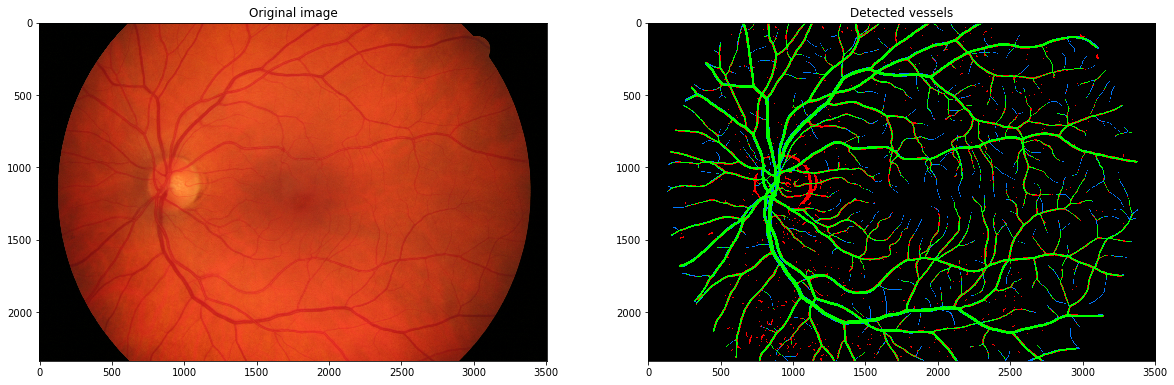

Accuracy: 95.86%
Sensitivity: 86.73%
Specificity: 96.89%
Sensitivity and specificity mean: 91.81%


In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import img_as_uint, img_as_float
from skimage.color import rgb2gray, gray2rgb
from skimage.morphology import disk, opening
from skimage.filters import sato, laplace
from termcolor import colored


def readImages(filename) :
    image = img_as_float(imageio.imread('images/' + filename + '.jpg'))
    mask = img_as_float(imageio.imread('mask/' + filename + '_mask' + '.tif'))
    manual = img_as_float(imageio.imread('manual1/' + filename + '.tif'))
    return (image, mask, manual)


def applyMask(img, mask) :
    for i in range (0, mask.shape[0]) :
        for j in range (0, mask.shape[1]) :
            if mask[i, j, 0] == 0 and mask[i, j, 1] == 0 and mask[i, j, 2] == 0:
                img[i, j] = 0
    
    return img


def count(tp, tn, fp, fn) :
    count_tp = 0
    count_tn = 0
    count_fp = 0
    count_fn = 0
    for i in range (0, tp.shape[0]) :
        for j in range (0, tp.shape[1]) :
            if(tp[i, j] == 1) :
                count_tp += 1
            if(tn[i, j] == 1) :
                count_tn += 1
            if(fp[i, j] == 1) :
                count_fp += 1
            if(fn[i, j] == 1) :
                count_fn += 1
                
    return (count_tp, count_tn, count_fp, count_fn)
                

def truePositive(img, manual) :
    true_positive = np.zeros(manual.shape)
    for i in range (0, manual.shape[0]) :
        for j in range (0, manual.shape[1]) :
            if manual[i, j] == 1 and img[i, j] == 1 :
                true_positive[i, j] = 1
    return true_positive


def trueNegative(img, manual) :
    true_negative = np.zeros(manual.shape)
    for i in range (0, manual.shape[0]) :
        for j in range (0, manual.shape[1]) :
            if manual[i, j] == 0 and img[i, j] == 0 :
                true_negative[i, j] = 1
    return true_negative


def falsePositive(img, manual) :
    false_positive = np.zeros(manual.shape)
    for i in range (0, manual.shape[0]) :
        for j in range (0, manual.shape[1]) :
            if manual[i, j] == 0 and img[i, j] == 1 :
                false_positive[i, j] = 1
    return false_positive


def falseNegative(img, manual) :
    false_negative = np.zeros(manual.shape)
    for i in range (0, manual.shape[0]) :
        for j in range (0, manual.shape[1]) :
            if manual[i, j] == 1 and img[i, j] == 0 :
                false_negative[i, j] = 1
    return false_negative
    

def coloring(img, true_positive, false_positive, false_negative) :
    img = gray2rgb(img_as_uint(img))
    for i in range (0, true_positive.shape[0]) :
        for j in range (0, true_positive.shape[1]) :
            if true_positive[i, j] == 1 :
                img[i, j, 0] = 0
                img[i, j, 1] = 255
                img[i, j, 2] = 0
            if false_positive[i, j] == 1 :
                img[i, j, 0] = 255
                img[i, j, 1] = 0
                img[i, j, 2] = 0
            if false_negative[i, j] == 1 :
                img[i, j, 0] = 0
                img[i, j, 1] = 120
                img[i, j, 2] = 255
    
    return img
        

def gamma(img) :
    g = np.mean(img) * 2.2
    return (img ** g)


def contrast(img) :
    percmin = 80.0
    percmax = 4.0
    MIN = np.percentile(img, percmin)
    MAX = np.percentile(img, 100 - percmax)
    norm = (img - MIN) / (MAX - MIN)
    norm[norm[:, :] > 1] = 1
    norm[norm[:, :] < 0] = 0
    return norm


def threshold(img) :
    return img > 0.1


# Wczytywanie pliku
filename = '06_h'
image, mask, manual = readImages(filename)

# Wstępne przetwarzenie
img_grey = rgb2gray(image)
img_sharpen = np.clip(laplace(img_grey) + img_grey, 0, 1)
img_gamma = gamma(img_sharpen)

# Właściwe przetwarzanie
img_sato = sato(img_gamma)
img_mask = applyMask(img_sato, mask)
img_contrast = contrast(img_mask)
img_threshold = threshold(img_contrast)
img_opening = opening(img_threshold, disk(2))

# Wyznaczenie macierzy pomyłek
tp = truePositive(img_opening, manual)
tn = trueNegative(img_opening, manual)
fp = falsePositive(img_opening, manual)
fn = falseNegative(img_opening, manual)
img_colored = coloring(img_opening, tp, fp, fn)

# Obliczanie miar oceny skuteczności algorytmu
count_tp, count_tn, count_fp, count_fn = count(tp, tn, fp, fn)

accuracy = ((count_tp + count_tn) / (count_tp + count_tn + count_fp + count_fn)) * 100
sensitivity = (count_tp / (count_tp + count_fn)) * 100
specificity = (count_tn / (count_tn + count_fp)) * 100
mean = (sensitivity + specificity) / 2

# Wyświetlanie wyników
print("Detected vessels:")
print(colored('green', 'green') + " - true positive")
print(colored('blue', 'blue') + " - false negative")
print(colored('red', 'red') + " - false positive")

plt.figure(1, figsize=(20,10))

plt.subplot(121)
plt.title("Original image")
plt.imshow(image, cmap=plt.cm.Greys_r)

plt.subplot(122)
plt.title("Detected vessels")
plt.imshow(img_colored, cmap=plt.cm.Greys_r)

plt.show()


print('Accuracy: ' + str(round(accuracy, 2)) + '%')
print('Sensitivity: ' + str(round(sensitivity, 2)) + '%')
print('Specificity: ' + str(round(specificity, 2)) + '%')
print('Sensitivity and specificity mean: ' + str(round(mean, 2)) + '%')
